In [15]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import zipfile

print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [17]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [50]:
train_set = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
test_set = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

In [51]:
img, label = next(iter(train_loader))
img[0].shape, label[0]

(torch.Size([1, 28, 28]), tensor(9))

In [52]:
len(train_set), len(test_set)

(60000, 10000)

Text(0.5, 1.0, '9')

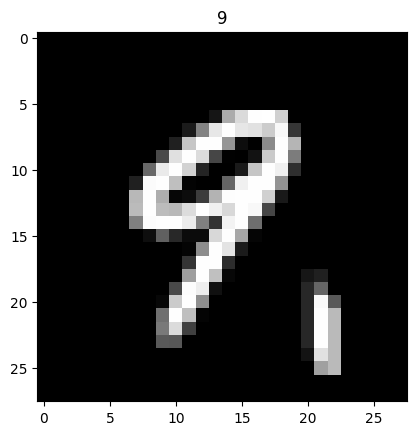

In [53]:
plt.imshow(img[0].squeeze(), cmap='gray')
plt.title(label[0].item())

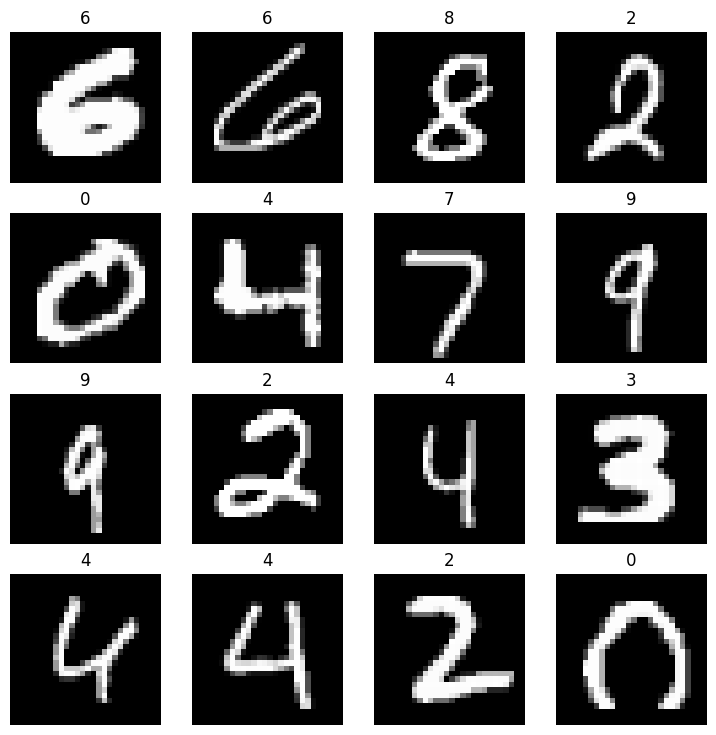

In [54]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_set), size=[1]).item()
    img, label = train_set[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(label)
    plt.axis(False)

In [55]:
torch.manual_seed(42)

class DigitMNISTModel(nn.Module):

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

In [56]:
learning_rate = 0.003
torch.manual_seed(42)

digit_model = DigitMNISTModel(input_shape=1, hidden_units=10, output_shape=10).to(device)
optimizer = torch.optim.SGD(digit_model.parameters(), lr=learning_rate, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [57]:
%load_ext autoreload
%autoreload 2

from engine import *
from tqdm.auto import tqdm

torch.manual_seed(42)

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_loader, 
        model=digit_model, 
        loss_fn=criterion,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_loader,
        model=digit_model,
        loss_fn=criterion,
        accuracy_fn=accuracy_fn,
        device=device
    )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.88504 | Train accuracy: 70.40%


 33%|███▎      | 1/3 [00:09<00:19,  9.69s/it]

Test loss: 0.15670 | Test accuracy: 95.02%

Epoch: 1
---------
Train loss: 0.13001 | Train accuracy: 96.02%


 67%|██████▋   | 2/3 [00:19<00:09,  9.59s/it]

Test loss: 0.09624 | Test accuracy: 96.86%

Epoch: 2
---------
Train loss: 0.09341 | Train accuracy: 97.12%


100%|██████████| 3/3 [00:28<00:00,  9.58s/it]

Test loss: 0.07819 | Test accuracy: 97.47%



In [78]:
img, label = next(iter(test_loader))
img[0].shape

torch.Size([1, 28, 28])

In [79]:
torch.manual_seed(42)
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [80]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_set), k=9):
    test_samples.append(sample)
    test_labels.append(label)

In [81]:

pred_probs=make_predictions(model=digit_model,
                            data=test_samples)

In [82]:
pred_probs[:2]

tensor([[4.4250e-08, 1.4956e-06, 9.9996e-01, 7.0995e-07, 4.7195e-13, 8.3980e-12,
         2.9605e-11, 1.2126e-08, 3.6363e-05, 3.8414e-09],
        [8.4193e-07, 9.9793e-01, 3.4375e-05, 2.0599e-05, 1.4741e-04, 1.2272e-04,
         8.9698e-05, 2.7637e-05, 1.6227e-03, 6.7726e-06]])

In [83]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([2, 1, 2, 4, 6, 6, 4, 9, 1])

In [84]:
pred_classes, test_labels

(tensor([2, 1, 2, 4, 6, 6, 4, 9, 1]), [2, 1, 2, 4, 6, 6, 4, 9, 1])

In [86]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
digit_model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_loader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = digit_model(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions: 100%|██████████| 157/157 [00:01<00:00, 140.10it/s]


In [1]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    %pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend

c:\Users\bohdan\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


mlxtend version: 0.22.0


In [4]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

class_names = train_set.classes

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_set.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

NameError: name 'train_set' is not defined